In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### **Importing libraries**

In [ ]:
#import non tensorflow libraries
import matplotlib.pyplot as plt
import os
import numpy as np
from PIL import Image
import pathlib
import IPython.display as display

#import tensorflow libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import accuracy_score , classification_report

In [ ]:
# Helper function to download data and extract

def get_data_extract():
  if "food-101" in os.listdir():
    print("Dataset already exists")
  else:
    tf.keras.utils.get_file(
    'food-101.tar.gz',
    'http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz',
    cache_subdir='/content',
    extract=True,
    archive_format='tar',
    cache_dir=None
    )
    print("Dataset downloaded and extracted!")

In [ ]:
# Download data and extract it to folder
get_data_extract()

4996284416/4996278331 [==============================] - 254s 0us/step
Dataset downloaded and extracted!


## **Data Preparation**

START SPLIT DATA

In [ ]:
import os, shutil

# Path to the directory where the original dataset was uncompressed
original_dataset_dir = 'food-101/images'
# Directory where you’ll store your smaller dataset
base_dir = 'split'
os.mkdir(base_dir)
# Directory for the training splits
train_dir = os.path.join(base_dir, 'train')
os.mkdir(train_dir)
# Directory for the test splits
valid_dir = os.path.join(base_dir, 'valid')
os.mkdir(valid_dir)
# Directory for the test splits
test_dir = os.path.join(base_dir, 'test')
os.mkdir(test_dir)

with open('food-101/meta/classes.txt', 'r') as txt:
    classes = [l.strip() for l in txt.readlines()]

def fn(direc):       # 1.Get file names from directory
    file_list=os.listdir(direc)
    return file_list

In [ ]:
101000*3/4 , (101000*0.5)/(4), (101000*0.5)/(4), len(classes), (101000*3)/(4)/len(classes),(101000*0.5)/(4)/len(classes)

(75750.0, 12625.0, 12625.0, 101, 750.0, 125.0)

In [ ]:
for cl in classes:
  train_cl_dir = os.path.join(train_dir, cl)
  os.mkdir(train_cl_dir)
  src_fnames = os.path.join(original_dataset_dir, cl)
  fnames = fn(src_fnames)
  for fname in fnames[0:750]:
      src = os.path.join(original_dataset_dir, cl, fname)
      dst = os.path.join(train_cl_dir, fname)
      shutil.copyfile(src, dst)


In [ ]:
for cl in classes:
  valid_cl_dir = os.path.join(valid_dir, cl)
  os.mkdir(valid_cl_dir)
  src_fnames = os.path.join(original_dataset_dir, cl)
  fnames = fn(src_fnames)

  for fname in fnames[750:875]:
      src = os.path.join(original_dataset_dir, cl, fname)
      dst = os.path.join(valid_cl_dir, fname)
      shutil.copyfile(src, dst)



In [ ]:
for cl in classes:
  test_cl_dir = os.path.join(test_dir, cl)
  os.mkdir(test_cl_dir)
  src_fnames = os.path.join(original_dataset_dir, cl)
  fnames = fn(src_fnames)

  for fname in fnames[875:]:
      src = os.path.join(original_dataset_dir, cl, fname)
      dst = os.path.join(test_cl_dir, fname)
      shutil.copyfile(src, dst)


END SPLIT DATA

In [ ]:
#initialise class names and view them
with open("food-101/meta/classes.txt", "r") as f:
    CLASS_NAMES = [item.strip() for item in f]
CLASS_NAMES = np.array(CLASS_NAMES)
print(len(CLASS_NAMES))

101


In [ ]:
#initialising necessary properties
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
STEPS_PER_EPOCH = np.ceil(10000/BATCH_SIZE)

#prepare train data generator with necessary augmentations and validation split
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

valid_datagen = ImageDataGenerator(
        rescale = 1./255
)
test_datagen = ImageDataGenerator(
        rescale = 1./255
)

In [ ]:
#initialise path
path = 'split'

#generate training data
print('Train Data')
train_data = train_datagen.flow_from_directory(
    path +'/train',
    batch_size=BATCH_SIZE,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical')

#generate validation data
print('\nValidation Data')
valid_data = valid_datagen.flow_from_directory(
    path +'/valid',
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical')

#generate test data
print('\nTest Data')
test_data = test_datagen.flow_from_directory(
    path +'/test',
    batch_size=BATCH_SIZE,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode = 'categorical')


Train Data
Found 75750 images belonging to 101 classes.

Validation Data
Found 12625 images belonging to 101 classes.

Test Data
Found 12625 images belonging to 101 classes.


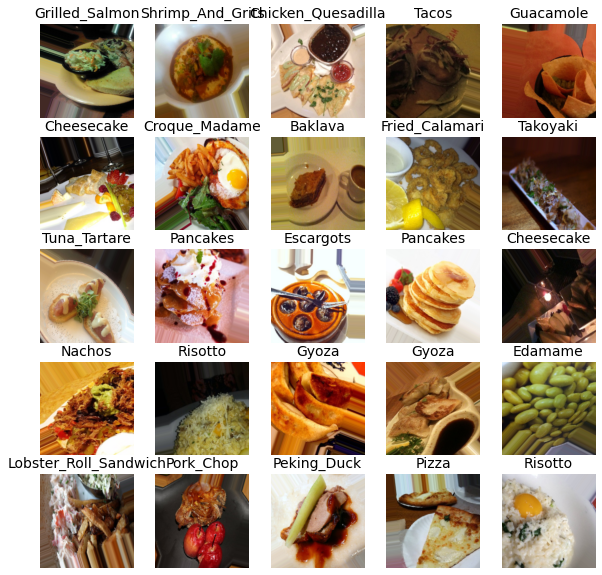

In [ ]:
#vizualise the loaded images
def show_batch(image_batch, label_batch):
  fig = plt.figure(figsize=(10,10))
  fig.patch.set_facecolor('white')
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title(), fontsize=14)
      plt.axis('off')
image_batch, label_batch = next(train_data)
show_batch(image_batch, label_batch)

## **Training with noisy labels**

## **MobileNetV2**

Fine Tuning the model by adding extra classification layers and training the entire models with imagenet weights.

In [ ]:
#import model
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
#initialise base model
IMG_SHAPE = (IMG_HEIGHT, IMG_WIDTH, 3)
base_model = VGG19(input_shape=IMG_SHAPE, input_tensor=None,
                                                include_top=False,
                                                weights='imagenet')
base_model.trainable = True

80142336/80134624 [==============================] - 1s 0us/step


In [ ]:
import tensorflow.keras.backend as K
from sklearn.metrics import roc_auc_score
from keras.callbacks import Callback

class CustomModel(tf.keras.Model):


    def flip_label(elf, y, pattern, n_class, ratio, one_hot=True):
        #y: true labesl, one hot
        #pattern: 'pair' or 'sym'
        #p: float, noisy ratio

        #convert one hot label to int
        t = y.numpy().astype(int)

        if one_hot:
           t = np.argmax(y,axis=1)#[np.where(r==1)[0][0] for r in y]


        #filp label
        for i in range(len(y)):
            if pattern=='sym':
                p1 = ratio/(n_class-1)*np.ones(n_class)
                p1[t[i]] = 1-ratio
                p1 /= p1.sum()  # normalize
                t[i] = np.random.choice(n_class,p=p1)

            elif pattern=='asym':
                t[i] = np.random.choice([t[i],(t[i]+1)%n_class],p=[1-ratio,ratio])

        #convert back to one hot
        if one_hot:
            t = np.eye(n_class)[t]
        noisy_y = tf.convert_to_tensor(t, dtype=tf.float32)
        return noisy_y

    @tf.function
    def train_step(self, data):
        # Unpack the data. Its structure depends on your model and
        # on what you pass to `fit()`.
        x, y = data
        y = self.flip_label(y, 'sym', len(CLASS_NAMES), 0.1, one_hot=True)
        with tf.GradientTape() as tape:
            y_pred = self(x, training=True)  # Forward pass
            # Compute the loss value
            # (the loss function is configured in `compile()`)
            loss = self.compiled_loss(y, y_pred, regularization_losses=self.losses)

        # Compute gradients
        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)
        # Update weights
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        # Update metrics (includes the metric that tracks the loss)
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value
        return {m.name: m.result() for m in self.metrics}


    @tf.function
    def test_step(self, data):
        # Unpack the data
        x, y = data
        y = self.flip_label(y, 'sym', len(CLASS_NAMES), 0.1, one_hot=True)
        # Compute predictions
        y_pred = self(x, training=False)
        # Updates the metrics tracking the loss
        self.compiled_loss(y, y_pred, regularization_losses=self.losses)
        # Update the metrics.
        self.compiled_metrics.update_state(y, y_pred)
        # Return a dict mapping metric names to current value.
        # Note that it will include the loss (tracked in self.metrics).
        return {m.name: m.result() for m in self.metrics}

    def make_train_function(self):
        if self.train_function is not None:
            return self.train_function
        def train_function(iterator):
            data = next(iterator)
            # store references to the model outputs, loss images
            # and loss histograms so that these can be recorded
            # to TensorBoard
            res  = self.train_step(data)
            return {m.name: m.result() for m in self.metrics}
        self.train_function = train_function
        return self.train_function



In [ ]:
epochs = 26

# Reduce learning rate when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.01,
                                                 patience = 3,
                                                 factor = 0.25,
                                                 verbose = 1,
                                                 cooldown = 0,
                                                 min_lr = 0.00000001)

# Stop the training process when there is a change lesser than <min_delta> in <val_accuracy> for more than <patience> epochs
early_stopper = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 mode = 'max',
                                                 min_delta = 0.005,
                                                 patience = 10,
                                                 verbose = 1,
                                                 restore_best_weights = True)

In [ ]:
from keras import backend as K
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
tf.config.run_functions_eagerly(True)

with tf.device("/GPU:0"):
    model = tf.keras.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(320, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(320, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.2))
    model.add(tf.keras.layers.Dense(101, activation='softmax'))
    #compile model

    c_model = CustomModel(model.input, model.output)
    c_model.compile(optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9),
          loss = tf.keras.losses.CategoricalCrossentropy(from_logits = True),
          metrics=['accuracy',f1_m,recall_m,precision_m,tf.keras.metrics.TopKCategoricalAccuracy(k=5) ],
          run_eagerly=True)

    history = c_model.fit(train_data,
                    epochs=epochs,
                    validation_data = valid_data,
                    callbacks=[early_stopper, reduce_lr]
                    )





/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/dataset_ops.py:3704: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  "Even though the `tf.config.experimental_run_functions_eagerly` "


Epoch 1/26


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:4870: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


2368/2368 [==============================] - 1630s 681ms/step - loss: 4.3214 - accuracy: 0.0583 - f1_m: 0.0105 - recall_m: 0.0055 - precision_m: 0.1291 - top_k_categorical_accuracy: 0.1754 - val_loss: 3.5468 - val_accuracy: 0.2026 - val_f1_m: 0.0749 - val_recall_m: 0.0403 - val_precision_m: 0.6467 - val_top_k_categorical_accuracy: 0.4356
Epoch 2/26
2368/2368 [==============================] - 1524s 644ms/step - loss: 3.4385 - accuracy: 0.2201 - f1_m: 0.0999 - recall_m: 0.0560 - precision_m: 0.6094 - top_k_categorical_accuracy: 0.4680 - val_loss: 2.9583 - val_accuracy: 0.3335 - val_f1_m: 0.2317 - val_recall_m: 0.1417 - val_precision_m: 0.7035 - val_top_k_categorical_accuracy: 0.6060
Epoch 3/26
2368/2368 [==============================] - 1490s 629ms/step - loss: 2.9666 - accuracy: 0.3325 - f1_m: 0.2064 - recall_m: 0.1236 - precision_m: 0.7231 - top_k_categorical_accuracy: 0.6007 - val_loss: 2.5315 - val_accuracy: 0.4477 - val_f1_m: 0.3571 - val_recall_m: 0.2368 - val_precision_m: 0.7657

In [ ]:
#get results
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#plot results
#accuracy
plt.figure(figsize=(8, 8))
plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['font.size'] = 14
plt.rcParams['axes.grid'] = True
plt.rcParams['figure.facecolor'] = 'white'
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title(f'MobileNetV2 \nTraining and Validation Accuracy. \nTrain Accuracy: {str(acc[-1])}\nValidation Accuracy: {str(val_acc[-1])}')

#loss
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title(f'Training and Validation Loss. \nTrain Loss: {str(loss[-1])}\nValidation Loss: {str(val_loss[-1])}')
plt.xlabel('epoch')
plt.tight_layout(pad=3.0)
plt.show()

In [ ]:
hist_df = pd.DataFrame(history.history)

# or save to csv:
hist_csv_file = 'historyVGG19noise30.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
results = c_model.evaluate(test_data, batch_size=BATCH_SIZE)

In [ ]:
number_of_examples = len(test_data.filenames)
number_of_generator_calls = np.ceil(12625/BATCH_SIZE)
# 1.0 above is to skip integer division

test_labels = []

for i in range(0,int(number_of_generator_calls)):
    test_labels.extend(np.array(test_data[i][1]))

In [ ]:
from sklearn.metrics import confusion_matrix,classification_report

In [ ]:
index = tf.argmax(test_labels, axis=1)

In [ ]:
predictions = np.argmax(model.predict(test_data), axis=1)

In [ ]:
cm = confusion_matrix( index, predictions)
clr = classification_report(index, predictions)

In [ ]:
plt.figure(figsize =(30,30))
sns.heatmap(cm, annot = True, fmt = 'g', vmin=0, cmap = 'Blues', cbar = False)
plt.xticks(ticks = np.arange(101) + 0.5, label = test_data.class_indices, rotation =90)
plt.yticks(ticks = np.arange(101) + 0.5, label = test_data.class_indices, rotation =0)
plt.xlabel('Predicted')
plt.ylabel('Actuall')
plt.title('confusion matrix')
plt.savefig('plot_confusion_matrixInception_N3.png')

In [ ]:
plt.figure(figsize =(30,30))
sns.heatmap(cm, annot = True, fmt = 'g', vmin=0, cmap = 'Blues', cbar = False)
plt.xticks(ticks = np.arange(101) + 0.5, label = test_data.class_indices, rotation =90)
plt.yticks(ticks = np.arange(101) + 0.5, label = test_data.class_indices, rotation =0)
plt.xlabel('Predicted')
plt.ylabel('Actuall')
plt.title('confusion matrix')
plt.savefig('plot_confusion_matrixInception_N3.png')

In [ ]:
np.argsort(np.diag(cm))